In [1]:
import os
import sys
import base64
import matplotlib.pyplot as plt
import numpy as np
from urllib import parse
import pandas as pd

current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, '..', '..')) 
if root_directory not in sys.path:
    sys.path.append(root_directory)

import logging
logging.basicConfig(level=logging.CRITICAL)

from code_utils.elastic import get_from_es, scroll_from_es

In [2]:
body = {
  "size": 0,
  "track_total_hits": True,
    "aggs": {
        "type": {
        "terms": {
            "field": "type.keyword",
            "size": 10000000
      }
    }
  }
}
data=get_from_es(body,'scanr-publications')

In [3]:
data

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 7166417, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'type': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'journal-article', 'doc_count': 2740258},
    {'key': 'book', 'doc_count': 1916653},
    {'key': 'other', 'doc_count': 1174608},
    {'key': 'book-chapter', 'doc_count': 477959},
    {'key': 'proceedings', 'doc_count': 436681},
    {'key': 'thesis', 'doc_count': 392683},
    {'key': 'preprint', 'doc_count': 19485},
    {'key': 'HDR', 'doc_count': 8090}]}}}

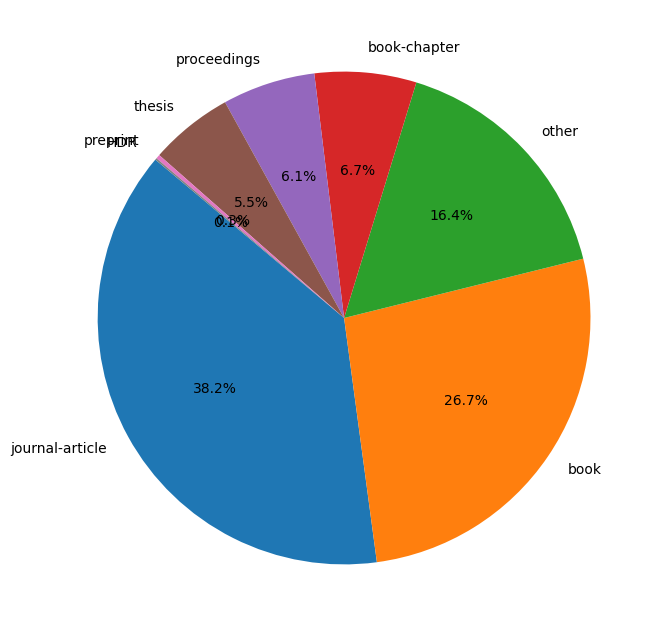

In [4]:
labels = [x['key'] for x in data['aggregations']['type']['buckets']]
sizes = [int(x['doc_count']) for x in data['aggregations']['type']['buckets']]

plt.figure(figsize=(8,8), facecolor='white')
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.show()

In [5]:
sum([int(x['doc_count']) for x in data['aggregations']['type']['buckets']])

7166417

In [6]:
body = {
  "size": 0,
  "track_total_hits": True,
  "query": {
    "bool": {
      "filter": {
       "exists": {
         "field": "id"
       }
      }
    }
  },
  "aggs": {
    "predicted_labels": {
      "terms": {
        "field": "predict_teds.label.keyword",
        "size": 10000000
      },
      "aggs": {
        "type": {
          "terms": {
            "field": "type.keyword",
            "size": 10000000
          }
        }
      }
    }
  }
}
data=get_from_es(body,'scanR2')

https://cluster-production.elasticsearch.dataesr.ovh/scanr-publications-20241119/_search


In [7]:
data

{'took': 2477,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 4111493, 'relation': 'eq'},
  'max_score': None,
  'hits': []},
 'aggregations': {'predicted_labels': {'doc_count_error_upper_bound': 0,
   'sum_other_doc_count': 0,
   'buckets': [{'key': 'not_ipcc',
     'doc_count': 4034650,
     'type': {'doc_count_error_upper_bound': 0,
      'sum_other_doc_count': 0,
      'buckets': [{'key': 'journal-article', 'doc_count': 2027661},
       {'key': 'other', 'doc_count': 683464},
       {'key': 'thesis', 'doc_count': 459594},
       {'key': 'book-chapter', 'doc_count': 368063},
       {'key': 'proceedings', 'doc_count': 294599},
       {'key': 'book', 'doc_count': 178319},
       {'key': 'preprint', 'doc_count': 17261},
       {'key': 'HDR', 'doc_count': 5689}]}},
    {'key': 'ipcc',
     'doc_count': 76843,
     'type': {'doc_count_error_upper_bound': 0,
      'sum_other_doc_count': 0,
      'buckets': [{'key': 'j

In [8]:
data['aggregations']['predicted_labels']['buckets'][1]

{'key': 'ipcc',
 'doc_count': 76843,
 'type': {'doc_count_error_upper_bound': 0,
  'sum_other_doc_count': 0,
  'buckets': [{'key': 'journal-article', 'doc_count': 58222},
   {'key': 'other', 'doc_count': 9621},
   {'key': 'book-chapter', 'doc_count': 4797},
   {'key': 'proceedings', 'doc_count': 2316},
   {'key': 'preprint', 'doc_count': 1027},
   {'key': 'book', 'doc_count': 583},
   {'key': 'thesis', 'doc_count': 266},
   {'key': 'HDR', 'doc_count': 11}]}}

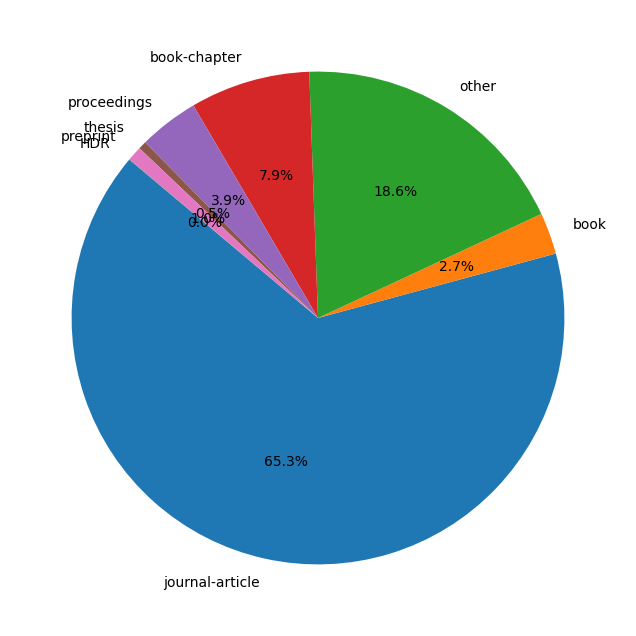

In [9]:
labels = ['journal-article','book','other','book-chapter','proceedings','thesis','preprint','HDR']
sizes = [x['doc_count']  for y in labels for x in data['aggregations']['predicted_labels']['buckets'][1]['type']['buckets'] if x['key']==y]
plt.figure(figsize=(8,8), facecolor='white')
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.show()

In [ ]:
#voir cb de % ipcc-like de scanR sont dans bso
#voir les grands thèmes associé aux ipcc-like dans le bso

In [19]:
df=pd.read_csv(root_directory+"\\bso-publications-latest.csv", sep=";")
counts = df['bso_classification'].value_counts()

C:\Users\haallat\AppData\Local\Temp\ipykernel_19092\1880636496.py:1: DtypeWarning: Columns (5,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv(root_directory+"\\bso-publications-latest.csv", sep=";")


In [20]:
len(df)

3386400

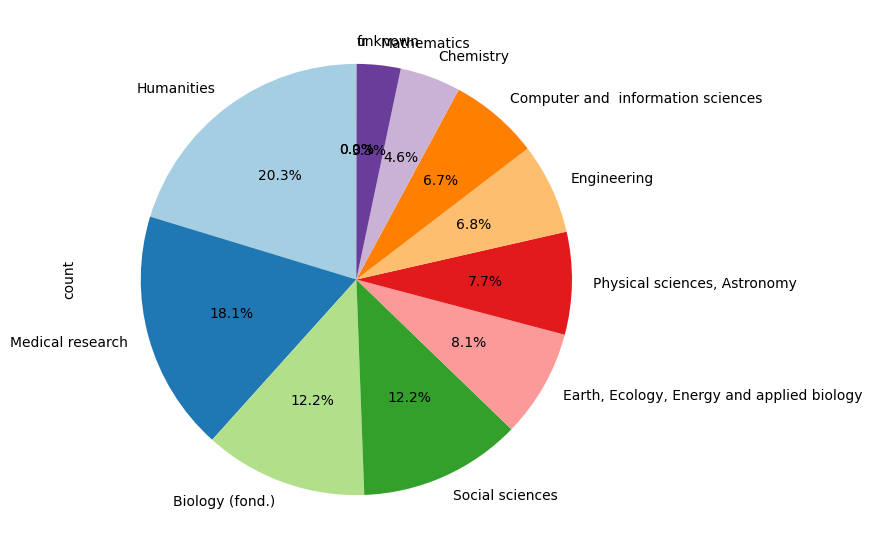

In [21]:
plt.figure(figsize=(7, 7), facecolor='white')
counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.show()

In [22]:
doi_bso=list(df.doi.drop_duplicates())

In [23]:
len(doi_bso)

2121961

In [51]:
id_bso=list(df.id.drop_duplicates())
len(id_bso)

3376364

In [47]:
body = {
  "size": 10000,  
  "track_total_hits": True,
  "_source": ["id"],  
  "query": { 
    "bool": {
      "must": [
        {
          "term": {
            "predict_teds.label.keyword": "ipcc"
          }
        },
        {
          "term": {
            "externalIds.type.keyword": "doi"
          }
        }
      ]
    }
  }
}


data = get_from_es(body, 'scanr', scroll=5)

In [42]:
len(data['hits']['hits'])

10000

In [48]:
ids = []

ids.extend([data['hits']['hits'][k]['_source']['id'].replace('doi','') for k in range(len(data['hits']['hits']))])
scroll_id = data['_scroll_id']

while len(ids)!=(data['hits']['total']['value']):
    print(len(ids))
    scroll_data = scroll_from_es(scroll_id, scroll="5m")
    ids.extend([scroll_data['hits']['hits'][k]['_source']['id'].replace('doi','') for k in range(len(scroll_data['hits']['hits']))])
    scroll_id = scroll_data['_scroll_id']

10000
20000
30000
40000


In [49]:
len(ids)

43984

In [50]:
pd.DataFrame(ids).to_json('50k.json')

In [61]:
ids50=list(pd.read_json('50k.json')[0])
ids70=list(pd.read_json('70k.json')[0])

In [62]:
ids_not_in_scanr=[x for x in ids70 if x not in ids50]

In [64]:
len(ids_not_in_scanr)

35362

In [66]:
ids_not_in_scanr[1]

'10.5194/egusphere-egu23-3330'

In [38]:
ids_in_bso=[x for x in doi_bso if x in ids]

In [39]:
len(ids_in_bso)

40774

In [41]:
len(ids_in_bso)*100/len(ids)

92.70189159694435

In [44]:
df_ipcclike_bso=df[df.doi.apply(lambda x: x in ids_in_bso)]

In [45]:
len(df_ipcclike_bso)

40779

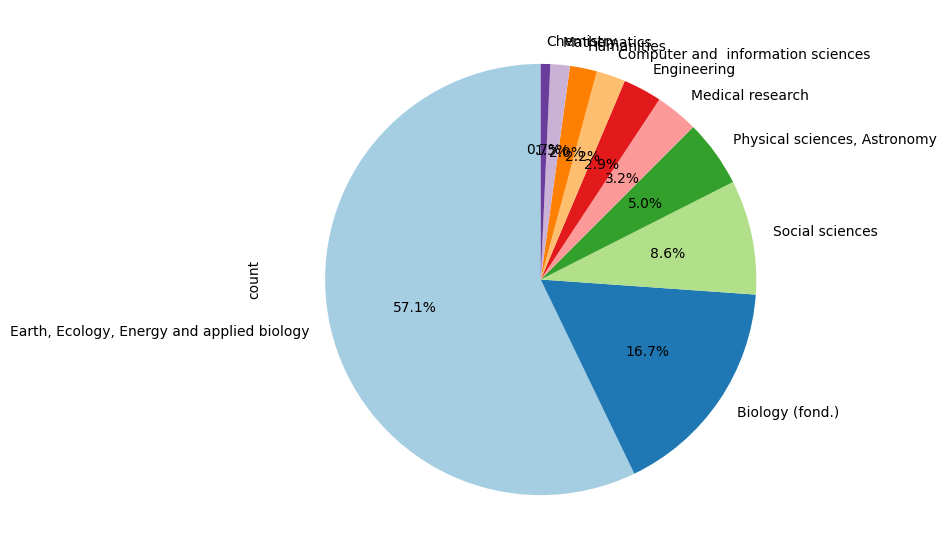

In [46]:
counts = df_ipcclike_bso['bso_classification'].value_counts()
plt.figure(figsize=(7, 7), facecolor='white')
counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.show()

In [ ]:
#check IPCC references type
df_unique_doi=pd.read_json(root_directory+f'\\IPCC_bibliography\\AR6\\structured_data\\data_model_ipcc\\data_ipcc.jsonl', orient='records', lines= True)

In [16]:
df_unique_doi.columns

Index(['index', 'doi', 'title', 'year', 'countries', 'concepts', 'sdg',
       'topics', 'is_OA_available', 'title_OA', 'year_OA', 'authors_name',
       'rors', 'institutions_names', 'locations_names', 'locations_ids',
       'type', 'type_crossref', 'test_glutton'],
      dtype='object')

In [17]:
df_unique_doi.type

0                book
1                book
2             article
3             article
4             article
             ...     
52593    book-chapter
52594         article
52595         article
52596         article
52597            book
Name: type, Length: 52598, dtype: object

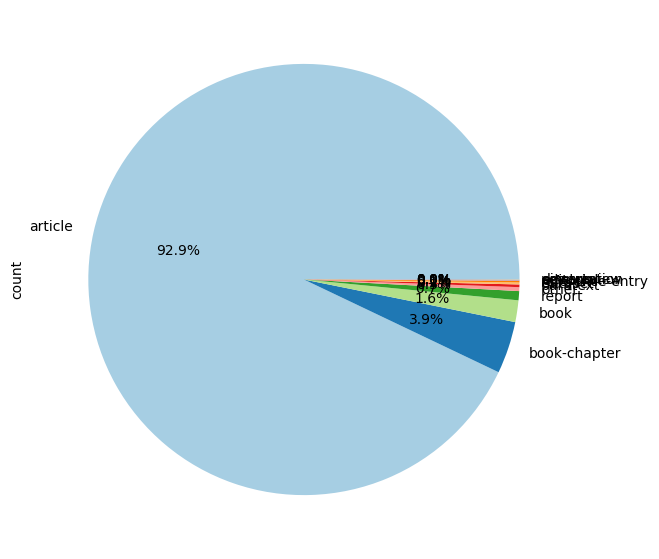

In [39]:
counts = df_unique_doi['type'].value_counts()
plt.figure(figsize=(7, 7), facecolor='white')
counts.plot.pie(autopct='%1.1f%%', startangle=0, colors=plt.cm.Paired.colors)
plt.show()

In [22]:
counts

type
article            48877
book-chapter        2055
book                 855
report               360
other                153
paratext             105
dataset               77
reference-entry       69
editorial             19
peer-review           16
erratum               10
dissertation           2
Name: count, dtype: int64